In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
img_size = (256, 256)

In [3]:
manga_data = tf.keras.utils.image_dataset_from_directory("archive", image_size=img_size, color_mode='grayscale')

Found 31771 files belonging to 1 classes.


In [4]:
manga_data_iterator = manga_data.as_numpy_iterator()

In [5]:
manga_batch = manga_data_iterator.next()

In [6]:
print(manga_batch[0].shape)

(32, 256, 256, 1)


In [7]:
photo_data = tf.keras.utils.image_dataset_from_directory("archive2", image_size=img_size, color_mode='grayscale')
photo_data_iterator = photo_data.as_numpy_iterator()

Found 31783 files belonging to 1 classes.


In [8]:
photo_batch = photo_data_iterator.next()

In [9]:
photo_batch[0].shape

(32, 256, 256, 1)

In [10]:
# fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
# for idx, img in enumerate(photo_batch[0][:4]):
#     ax[idx].imshow(img.astype(int))
#     ax[idx].title.set_text(f"Label: {photo_batch[1][idx]}")

## Preprocess

In [11]:
# normalizing the photos and manga data
manga_data = manga_data.map(lambda x,y: (x/255, y))
photo_data = photo_data.map(lambda x,y: (x/255, y))

In [12]:
# fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
# for idx, img in enumerate(manga_batch[0][:4]):
#     ax[idx].imshow(img.astype(int))
#     ax[idx].title.set_text(f"Label: {manga_batch[1][idx]}")

## Discriminator

In [13]:
def make_discriminator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(16, (3, 3), strides=(2, 2), padding='same', input_shape=[256, 256, 1]))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Conv2D(16, (3, 3), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [14]:
D = make_discriminator()
D.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      160       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 16)      0         
                                                                 
 dropout (Dropout)           (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 16)        2320      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 16)        0         
                                                                 
 dropout_1 (Dropout)         (None, 64, 64, 16)        0         
                                                                 
 flatten (Flatten)           (None, 65536)             0

In [15]:
#create generator with the output size as the input size of the discriminator
def make_generator():
    # model = tf.keras.Sequential()
    # model.add(tf.keras.layers.Dense(16 * 115 * 165, input_dim=100))
    # model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    # model.add(tf.keras.layers.Reshape((115, 165, 16)))
    # model.add(tf.keras.layers.Conv2DTranspose(16, (4, 4), strides=(2, 2), padding='same'))
    # model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    # model.add(tf.keras.layers.Conv2DTranspose(16, (4, 4), strides=(2, 2), padding='same'))
    # model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    # model.add(tf.keras.layers.Conv2D(3, (7, 7), activation='sigmoid', padding='same'))

    # write the model here that gives the ouput of the same size as the input of the discriminator
    # output size should be (256, 256, 1)
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(16 * 128 * 128, input_dim=100))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Reshape((128, 128, 16)))
    model.add(tf.keras.layers.Conv2DTranspose(16, (4, 4), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Conv2DTranspose(16, (4, 4), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Conv2D(1, (7, 7), activation='sigmoid', padding='same'))
    model.add(tf.keras.layers.MaxPool2D((2, 2), strides=(2, 2), padding='same'))

    return model

In [16]:
G = make_generator()
G.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 262144)            26476544  
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 262144)            0         
                                                                 
 reshape (Reshape)           (None, 128, 128, 16)      0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 256, 256, 16)      4112      
 anspose)                                                        
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 256, 256, 16)      0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 512, 512, 16)      4112      
 Transpose)                                           

In [17]:
def define_gan(generator, discriminator):
    discriminator.trainable = False
    model = tf.keras.Sequential()
    model.add(generator)
    model.add(discriminator)
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [18]:
def generate_real_samples(dataset, n_samples):
    ix = np.random.randint(0, dataset[0].shape[0], n_samples)
    X = dataset[0]
    y = np.ones((n_samples, 1))
    return X, y
    # return 1, 0

def generate_latent_points(latent_dim, n_samples):
    x_input = np.random.randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

def generate_fake_samples(generator, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = generator.predict(x_input)
    y = np.zeros((n_samples, 1))

    # save the image
    for i in range(n_samples):
        plt.imsave(f"generated_images/{i}.png", X[i].reshape(256, 256), cmap='gray')

    return X, y

In [19]:
# create a line plot of loss for the gan and save to file
def plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist):
    print("plotting history")
    # plot loss
    plt.subplot(2, 1, 1)
    plt.plot(d1_hist, label='d-real')
    plt.plot(d2_hist, label='d-fake')
    plt.plot(g_hist, label='gen')
    plt.legend()
    # plot discriminator accuracy
    plt.subplot(2, 1, 2)
    plt.plot(a1_hist, label='acc-real')
    plt.plot(a2_hist, label='acc-fake')
    plt.legend()
    # save plot to file
    
    plt.show()

    plt.savefig('history/plot_line_plot_loss.png')
    plt.close()



In [20]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=64):
    batch_per_epoch = len(dataset)
    half_batch = int(n_batch / 2)


    d1_hist, d2_hist, g_hist, a1_hist, a2_hist = list(), list(), list(), list(), list()

    for i in range(n_epochs):
        d_acc_real, d_acc_fake = 0.0, 0.0  # Initialize accuracy variables

        for j in range(50):

            data_itr = dataset.as_numpy_iterator()

            X_real, y_real = generate_real_samples(data_itr.next(), half_batch)

            d_loss1, d_acc1 = d_model.train_on_batch(X_real, y_real)
            d_acc_real += d_acc1  # Accumulate real accuracy

            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)

            d_loss2, d_acc2 = d_model.train_on_batch(X_fake, y_fake)
            d_acc_fake += d_acc2  # Accumulate fake accuracy

            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = np.ones((n_batch, 1))

            g_loss = gan_model.train_on_batch(X_gan, y_gan)

            d1_hist.append(d_loss1)
            d2_hist.append(d_loss2)
            g_hist.append(g_loss)
            a1_hist.append(d_acc1)
            a2_hist.append(d_acc2)

            print(f"Epoch: {i}, Batch: {j}, d_loss1: {d_loss1}, d_loss2: {d_loss2}, g_loss: {g_loss}")

        # Calculate average accuracy for real and fake samples
        d_acc_real /= batch_per_epoch
        d_acc_fake /= batch_per_epoch

        print(f"Epoch: {i}, d_acc_real: {d_acc_real}, d_acc_fake: {d_acc_fake}")

        plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist)
        
        # Save the generator model for every epoch
        g_model.save(f"generator_model/generator_model_{i}.h5")
        


In [ ]:
if not os.path.exists('generated_images'):
    os.makedirs('generated_images')

if not os.path.exists('generated_model'):
    os.makedirs('generated_model')

if not os.path.exists('results_baseline'):
    os.makedirs('results_baseline')

if not os.path.exists('history'):
    os.makedirs('history')

1/1 [==============================] - 1s 846ms/step
Epoch: 0, Batch: 0, d_loss1: 0.6817412376403809, d_loss2: 1.1173946857452393, g_loss: 0.49736514687538147
1/1 [==============================] - 1s 652ms/step
Epoch: 0, Batch: 1, d_loss1: 0.44951069355010986, d_loss2: 1.0863237380981445, g_loss: 0.5435970425605774
1/1 [==============================] - 1s 655ms/step
Epoch: 0, Batch: 2, d_loss1: 0.5148165225982666, d_loss2: 0.9251627922058105, g_loss: 0.6057295799255371
Epoch: 0, d_acc_real: 0.002580563947633434, d_acc_fake: 0.0
plotting history


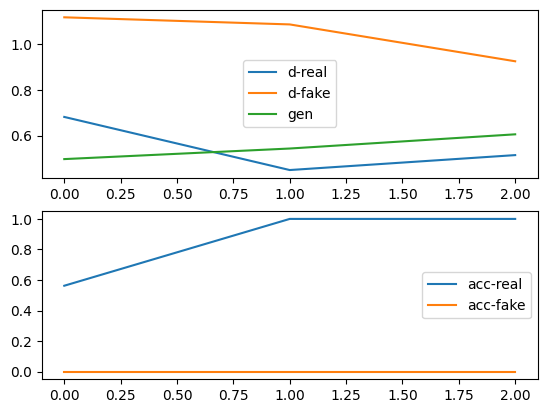

/Users/sasha/Desktop/Manga-Generator/venv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 1s 660ms/step
Epoch: 1, Batch: 0, d_loss1: 0.5670013427734375, d_loss2: 0.8692074418067932, g_loss: 0.6389428377151489
1/1 [==============================] - 1s 678ms/step
Epoch: 1, Batch: 1, d_loss1: 0.6209142208099365, d_loss2: 0.8528114557266235, g_loss: 0.6423851847648621
1/1 [==============================] - 1s 678ms/step
Epoch: 1, Batch: 2, d_loss1: 0.6066315770149231, d_loss2: 0.8994362950325012, g_loss: 0.6445135474205017
Epoch: 1, d_acc_real: 0.0024546827794561933, d_acc_fake: 0.0
plotting history


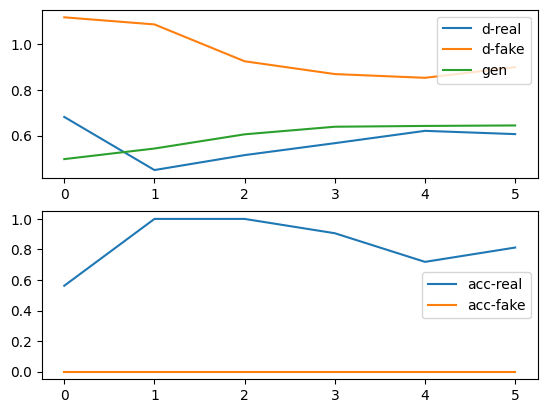

1/1 [==============================] - 1s 710ms/step


KeyboardInterrupt: 

In [21]:
train(G, D, define_gan(G, D), manga_data, 100, 64)